Define the time series of the fluxes between and within macrorregions.


-> Investigar as diferenças do Infomap, Louvain and Stochastic Block Model

-> Checar se existe algum parâmetro a ser ajustado no algoritmo de Infomap

-> Redes e mapas estratificados por CID

-> Caracterizar a conectividade das redes (rankear por in-degree)

-> Levar os equipamentos de saúde em conta e considerar possibilidades de normalização dos fluxos por número ou outra característica dos equipamentos de saúde

-> Calcular o valor de fluxo interno da macrorregião e os fluxos de saída e entrada para cada uma das macrorregiões

-> Explorar a rede de hospitais (projeção da rede bipartida município-hospital)

# **Bib**

In [1]:
import os
import sys
sys.path.append("..")

import glob
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
import geopandas as gpd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from fluxsus.DBFIX import DBFIX
#from fluxsus.fluxnets.fluxnets import CityFlux, CityHospitalFlux
from pathlib import Path
from fluxsus.utils_ import f_infomap
from scipy.stats import linregress

PyTables is not installed. No support for HDF output.


## Calculate the temporal data for flows

In [2]:
# -- Open the three main datasets: CNES, CE GEODATA, SIHSUS.
basepath = os.path.join(os.environ["HOMEPATH"], "Documents", "data")
sihpath = os.path.join(basepath, "opendatasus", "sihsus", "PARQUET")
cnespath = os.path.join(basepath, "opendatasus", "cnes")
geopath = os.path.join(basepath, "shapefilesceqgis")
gml_folder = os.path.join(basepath, "redes_aih", "snapshots")

geodata_df = gpd.read_parquet(os.path.join(geopath, "ce_geodata.parquet"))
cnes_df = pd.read_parquet(os.path.join(cnespath, "cnes_st_0801_2312.parquet"))
macro_aux = geodata_df.drop_duplicates("MACRO_ID")[["MACRO_ID", "MACRO_NOME"]]
macro_dict = dict(zip(macro_aux["MACRO_ID"], macro_aux["MACRO_NOME"]))

In [3]:
Path()

WindowsPath('.')

In [4]:
# -- time partition used
start = dt.datetime(2008, 1, 1)
end = dt.datetime(2022, 12, 31)
delta = 90 # aggregated network over 90 days

last = start
timelst = []
while last<end:
    timelst.append(last)
    last += timedelta(days=delta)
if last!=end: timelst.append(end)

# -- load all networks following the temporal order
#list_of_networks = [ nx.read_gml(os.path.join(gml_folder, f"cityfluxnet_allicd_{timelst[n].strftime('%Y-%m-%d')}_{timelst[n+1].strftime('%Y-%m-%d')}.gml")) for n in range(len(timelst)-1) ]
list_of_networks = [ nx.read_gml(os.path.join(gml_folder, f"citynet_allicd_{timelst[n].strftime('%Y-%m-%d')}_{timelst[n+1].strftime('%Y-%m-%d')}.gml")) for n in range(len(timelst)-1) ]

### Define utility functions

Calculate the incoming, outcoming and internal flows for each macrorregion.

In [5]:
def get_fluxes_macro(graph, macro_indices=["1", "2", "3", "4", "5"]):
    '''
        Calculate the incoming and outgoing fluxes for each macro. Also calculate the internal flux. 
    '''
    # -- initialize flows dict.
    macro_in_out = {
        ind: {
            "INCOMING": 0,
            "OUTGOING": 0,
            "INTERNAL": 0
        } for ind in macro_indices
    }

    # -- calculation
    for src, tgt in graph.edges():
        cur_action = graph.edges[(src, tgt)]
        
        src_macro, tgt_macro = str(int(cur_action['source_macro'])), str(int(cur_action['target_macro']))
        flux_count = cur_action['admission_count']

        if src_macro==tgt_macro:
            macro_in_out[src_macro]["INTERNAL"] += flux_count
        else:
            macro_in_out[src_macro]["OUTGOING"] += flux_count
            macro_in_out[tgt_macro]["INCOMING"] += flux_count
    return macro_in_out

def macro_flows_time(list_of_graphs, macro_indices=["1", "2", "3", "4", "5"]):
    ''' 
    
    '''
    # -- initialize flows dict.
    macro_in_out = {
        ind: {
            "INCOMING": [],
            "OUTGOING": [],
            "INTERNAL": []
        } for ind in macro_indices
    }
    for graph in list_of_graphs:
        res = get_fluxes_macro(graph)
        for key in res.keys():
            macro_in_out[key]["INCOMING"].append(res[key]["INCOMING"])
            macro_in_out[key]["OUTGOING"].append(res[key]["OUTGOING"])
            macro_in_out[key]["INTERNAL"].append(res[key]["INTERNAL"])
    return macro_in_out

### Plot time series for each macro



In [6]:
macro_flows = macro_flows_time(list_of_networks)

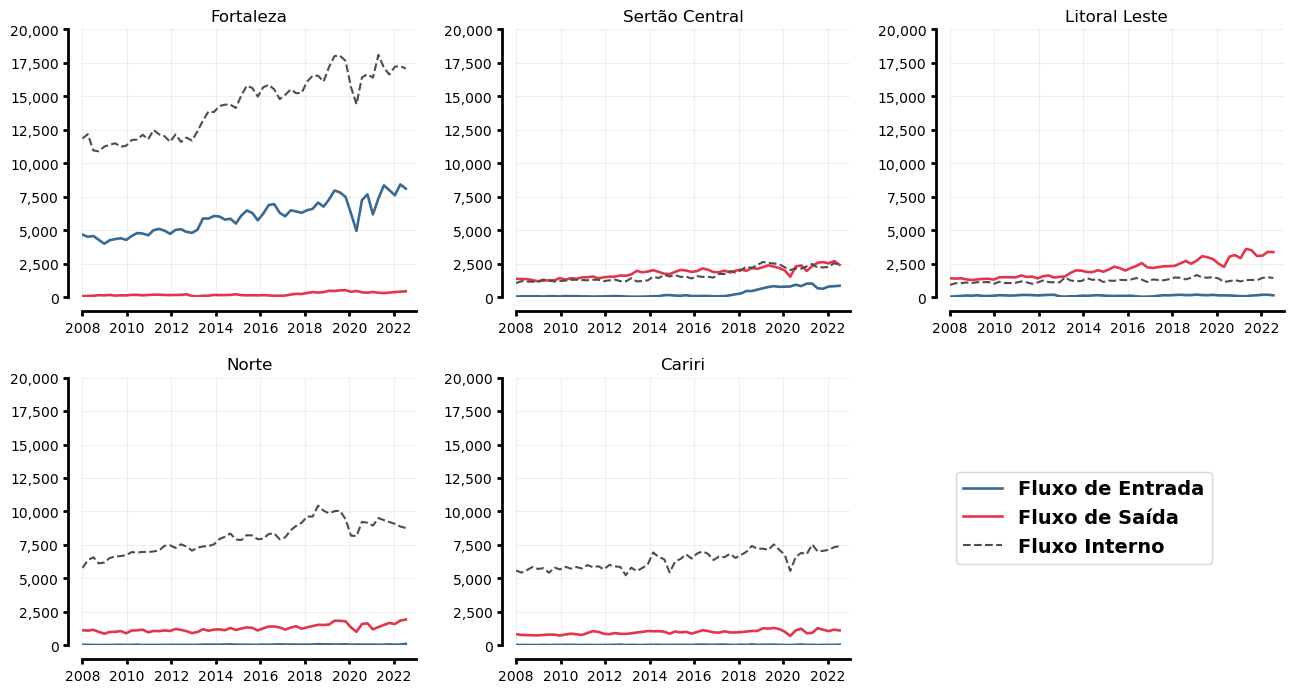

In [7]:
fig, AX = plt.subplots(2,3, figsize=(15.5,8), sharey=False)

AX[1,2].axis('off')

AX[0,0].set_title(macro_dict[1].replace("Superintendência Regional de Saúde ", ""))
linein, = AX[0,0].plot(timelst[:-2], macro_flows["1"]["INCOMING"][:-1], color="#396a93", lw=1.9)
lineout, = AX[0,0].plot(timelst[:-2], macro_flows["1"]["OUTGOING"][:-1], color="#e1374b", lw=1.9)
lineins, = AX[0,0].plot(timelst[:-2], macro_flows["1"]["INTERNAL"][:-1], color='#4d4d4d', ls="--")

AX[0,1].set_title(macro_dict[2].replace("Superintendência Regional de Saúde ", ""))
AX[0,1].plot(timelst[:-2], macro_flows["2"]["INCOMING"][:-1], color="#396a93", lw=1.9)
AX[0,1].plot(timelst[:-2], macro_flows["2"]["OUTGOING"][:-1], color="#e1374b", lw=1.9)
AX[0,1].plot(timelst[:-2], macro_flows["2"]["INTERNAL"][:-1], color='#4d4d4d', ls="--")

AX[0,2].set_title(macro_dict[3].replace("Superintendência Regional de Saúde ", ""))
AX[0,2].plot(timelst[:-2], macro_flows["3"]["INCOMING"][:-1], color="#396a93", lw=1.9)
AX[0,2].plot(timelst[:-2], macro_flows["3"]["OUTGOING"][:-1], color="#e1374b", lw=1.9)
AX[0,2].plot(timelst[:-2], macro_flows["3"]["INTERNAL"][:-1], color='#4d4d4d', ls="--")

AX[1,0].set_title(macro_dict[4].replace("Superintendência Regional de Saúde ", ""))
AX[1,0].plot(timelst[:-2], macro_flows["4"]["INCOMING"][:-1], color="#396a93", lw=1.9)
AX[1,0].plot(timelst[:-2], macro_flows["4"]["OUTGOING"][:-1], color="#e1374b", lw=1.9)
AX[1,0].plot(timelst[:-2], macro_flows["4"]["INTERNAL"][:-1], color='#4d4d4d', ls="--")

AX[1,1].set_title(macro_dict[5].replace("Superintendência Regional de Saúde ", ""))
AX[1,1].plot(timelst[:-2], macro_flows["5"]["INCOMING"][:-1], color="#396a93", lw=1.9)
AX[1,1].plot(timelst[:-2], macro_flows["5"]["OUTGOING"][:-1], color="#e1374b", lw=1.9)
AX[1,1].plot(timelst[:-2], macro_flows["5"]["INTERNAL"][:-1], color='#4d4d4d', ls="--")

fig.legend([linein, lineout, lineins], ['Fluxo de Entrada', 'Fluxo de Saída', 'Fluxo Interno'], loc=4, bbox_to_anchor=((0.86,0.2)), prop={'size':14, 'weight': 'bold'})


for i in range(2):
    for j in range(3):
        AX[i,j].grid(alpha=0.2, zorder=0)
        for sp in ['left', 'right', 'bottom', 'top']:
            AX[i,j].spines[sp].set_linewidth(2)
            AX[i,j].spines[sp].set_position(('outward', 10))
        AX[i,j].spines['right'].set_linewidth(0)
        AX[i,j].spines['top'].set_linewidth(0)
        AX[i,j].yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        AX[i,j].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
        AX[i,j].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        AX[i,j].tick_params(width=2)
        AX[i,j].set_xlim([timelst[0],timelst[-1]])
        AX[i,j].set_ylim([0,20000])
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig.savefig(os.path.join(basepath, "redes_aih", "doc_final", "flux_same_scale_90days.png"), dpi=250, bbox_inches='tight')

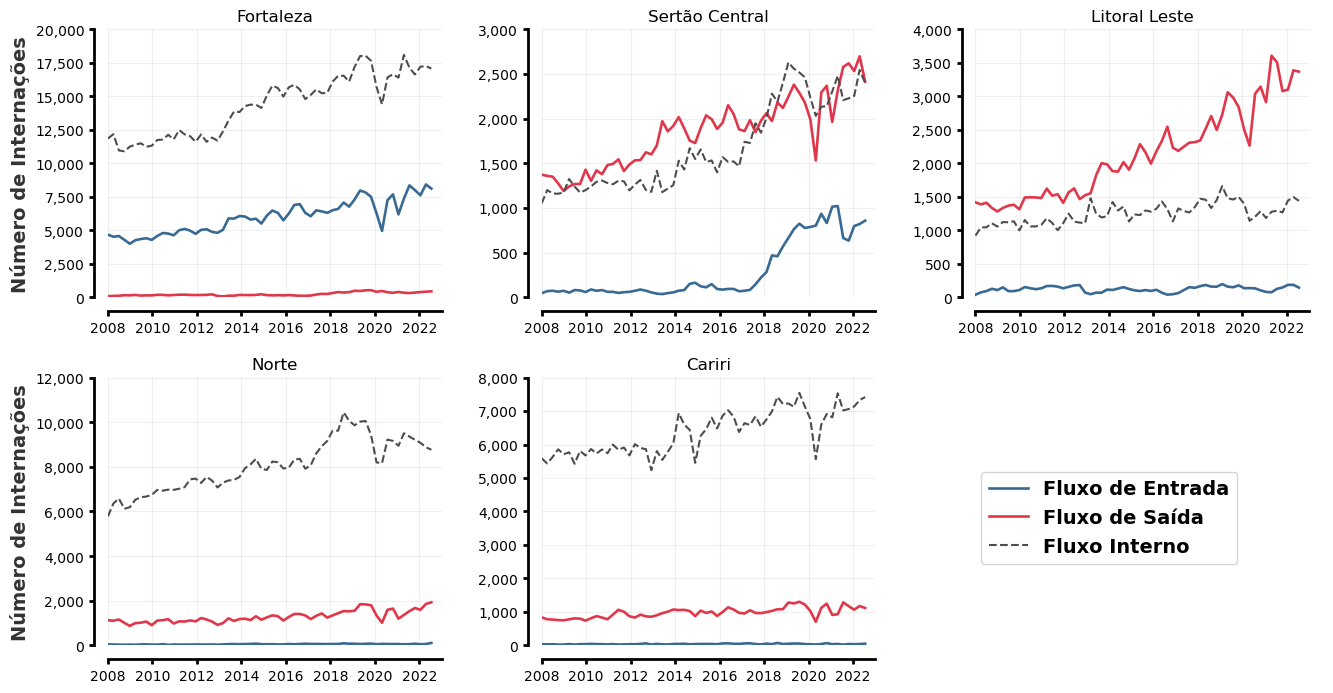

In [9]:
fig, AX = plt.subplots(2,3, figsize=(15.5,8), sharey=False)

AX[1,2].axis('off')

AX[0,0].set_title(macro_dict[1].replace("Superintendência Regional de Saúde ", ""))
linein, = AX[0,0].plot(timelst[:-2], macro_flows["1"]["INCOMING"][:-1], color="#396a93", lw=1.9)
lineout, = AX[0,0].plot(timelst[:-2], macro_flows["1"]["OUTGOING"][:-1], color="#e1374b", lw=1.9)
lineins, = AX[0,0].plot(timelst[:-2], macro_flows["1"]["INTERNAL"][:-1], color='#4d4d4d', ls="--")

AX[0,1].set_title(macro_dict[2].replace("Superintendência Regional de Saúde ", ""))
AX[0,1].plot(timelst[:-2], macro_flows["2"]["INCOMING"][:-1], color="#396a93", lw=1.9)
AX[0,1].plot(timelst[:-2], macro_flows["2"]["OUTGOING"][:-1], color="#e1374b", lw=1.9)
AX[0,1].plot(timelst[:-2], macro_flows["2"]["INTERNAL"][:-1], color='#4d4d4d', ls="--")

AX[0,2].set_title(macro_dict[3].replace("Superintendência Regional de Saúde ", ""))
AX[0,2].plot(timelst[:-2], macro_flows["3"]["INCOMING"][:-1], color="#396a93", lw=1.9)
AX[0,2].plot(timelst[:-2], macro_flows["3"]["OUTGOING"][:-1], color="#e1374b", lw=1.9)
AX[0,2].plot(timelst[:-2], macro_flows["3"]["INTERNAL"][:-1], color='#4d4d4d', ls="--")

AX[1,0].set_title(macro_dict[4].replace("Superintendência Regional de Saúde ", ""))
AX[1,0].plot(timelst[:-2], macro_flows["4"]["INCOMING"][:-1], color="#396a93", lw=1.9)
AX[1,0].plot(timelst[:-2], macro_flows["4"]["OUTGOING"][:-1], color="#e1374b", lw=1.9)
AX[1,0].plot(timelst[:-2], macro_flows["4"]["INTERNAL"][:-1], color='#4d4d4d', ls="--")

AX[1,1].set_title(macro_dict[5].replace("Superintendência Regional de Saúde ", ""))
AX[1,1].plot(timelst[:-2], macro_flows["5"]["INCOMING"][:-1], color="#396a93", lw=1.9)
AX[1,1].plot(timelst[:-2], macro_flows["5"]["OUTGOING"][:-1], color="#e1374b", lw=1.9)
AX[1,1].plot(timelst[:-2], macro_flows["5"]["INTERNAL"][:-1], color='#4d4d4d', ls="--")

fig.legend([linein, lineout, lineins], ['Fluxo de Entrada', 'Fluxo de Saída', 'Fluxo Interno'], loc=4, bbox_to_anchor=((0.86,0.2)), prop={'size':14, 'weight': 'bold'})


for i in range(2):
    for j in range(3):
        AX[i,j].grid(alpha=0.2, zorder=0)
        for sp in ['left', 'right', 'bottom', 'top']:
            AX[i,j].spines[sp].set_linewidth(2)
            AX[i,j].spines[sp].set_position(('outward', 10))
        AX[i,j].spines['right'].set_linewidth(0)
        AX[i,j].spines['top'].set_linewidth(0)
        AX[i,j].yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        AX[i,j].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
        AX[i,j].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        AX[i,j].tick_params(width=2)
        AX[i,j].set_xlim([timelst[0],timelst[-1]])
        #AX[i,j].set_ylim([0,20000])

AX[0,0].set_ylabel("Número de Internações", fontsize=13, weight='bold', color="#333333")
AX[1,0].set_ylabel("Número de Internações", fontsize=13, weight='bold', color="#333333")

AX[0,0].set_ylim([0,20000])
AX[0,1].set_ylim([0,3000])
AX[0,2].set_ylim([0,4000])
AX[1,0].set_ylim([0,12000])
AX[1,1].set_ylim([0,8000])
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig.savefig(os.path.join(basepath, "redes_aih", "doc_final", "flux_diff_scale_90days.png"), dpi=250, bbox_inches='tight')

In [18]:
timelst[-1]

datetime.datetime(2022, 12, 31, 0, 0)

### Normalize flows on the number of hospital beds

In [21]:
cnes_df["NUMLEITOS"] = cnes_df[["QTLEITP1", "QTLEITP2", "QTLEITP3"]].sum(axis=1)
cnes_df.sort_values(by="NUMLEITOS", ascending=False)[:5]

,CNES,CODUFMUN,COD_CEP,CPF_CNPJ,PF_PJ,NIV_DEP,CNPJ_MAN,COD_IR,REGSAUDE,MICR_REG,...,AP01CV07,AP02CV07,AP03CV07,AP04CV07,AP05CV07,AP06CV07,AP07CV07,latitude,longitude,NUMLEITOS
13842,2529149,230440,60025001,07835044000180,3,1,00000000000000,None,0001,None,...,0,0,0,0,0,0,0,-3.733574,-38.531145,553
14076,2497654,230440,60175295,07954571001429,3,3,07954571000104,None,0001,None,...,0,0,0,0,0,0,0,-3.733517,-38.480579,518
14330,2479214,230440,60840285,07954571002239,3,3,07954571000104,None,0001,None,...,0,0,0,0,0,0,0,-3.829356,-38.493713,448
12347,3021114,231290,62010550,07818313000109,3,1,00000000000000,None,11,None,...,0,0,0,0,0,0,0,-3.692842,-40.357658,325
5053,6848710,231290,62030340,00000000000000,3,3,07954571000104,None,11,None,...,0,0,0,0,0,0,0,-3.539871,-40.455866,312


In [22]:
#cnes_df1 = cnes_df[~cnes_df["COMPETEN"].str.contains('2023')]
leitos_aux = cnes_df.groupby(["CODUFMUN"])["NUMLEITOS"].sum().reset_index().rename({"CODUFMUN": "GEOCOD6"}, axis=1)
geodata_df1 = geodata_df.merge(leitos_aux, on="GEOCOD6", how="left")
geodata_df1["NUMLEITOS"] = geodata_df1["NUMLEITOS"].fillna(0)

In [23]:
geodata_df1.head()

,GEOCOD7,NM_MUNICIP,GEOCOD6,MACRO_ID,CRES_ID,geometry_municip,MACRO_NOME,geometry_macro,geometry_cres,centroid_municip,municip_lon,municip_lat,NUMLEITOS
0,2300101,ABAIARA,230010,5,19,"POLYGON ((-39.08246 -7.29577, -39.08347 -7.292...",Superintendência Regional de Saúde Cariri,"POLYGON ((-38.67306 -6.70700, -38.67306 -6.707...","POLYGON ((-4354692.823 -865196.973, -4354812.2...",POINT (-39.03754 -7.35991),-39.037538,-7.359907,0
1,2300150,ACARAPE,230015,1,3,"POLYGON ((-38.67268 -4.27393, -38.67268 -4.273...",Superintendência Regional de Saúde Fortaleza,"MULTIPOLYGON (((-39.69667 -2.99902, -39.69216 ...","POLYGON ((-4325426.833 -465433.632, -4325426.8...",POINT (-38.66305 -4.22242),-38.663052,-4.222417,0
2,2300200,ACARAÚ,230020,4,12,"POLYGON ((-39.99113 -3.09797, -39.99117 -3.098...",Superintendência Regional de Saúde Norte,"MULTIPOLYGON (((-39.90892 -3.27414, -39.90892 ...","POLYGON ((-4503430.806 -312287.468, -4503430.7...",POINT (-40.08913 -2.96792),-40.089128,-2.967916,38
3,2300309,ACOPIARA,230030,5,18,"POLYGON ((-39.21390 -5.99175, -39.21278 -5.991...",Superintendência Regional de Saúde Cariri,"POLYGON ((-38.67306 -6.70700, -38.67306 -6.707...","POLYGON ((-4440719.425 -681940.298, -4440964.9...",POINT (-39.49282 -6.12241),-39.492823,-6.122411,120
4,2300408,AIUABA,230040,2,14,"POLYGON ((-40.14849 -6.36051, -40.14816 -6.360...",Superintendência Regional de Saúde Sertão Central,"POLYGON ((-40.08511 -6.36860, -40.08445 -6.370...","POLYGON ((-4448196.104 -680357.114, -4447996.7...",POINT (-40.29895 -6.60520),-40.298951,-6.605196,22


In [24]:
leitos_macro = geodata_df1.groupby("MACRO_ID")["NUMLEITOS"].sum().reset_index()
leitos_macro = dict(zip(leitos_macro["MACRO_ID"], leitos_macro["NUMLEITOS"]))

macro_flows1 = macro_flows_time(list_of_networks)
for key in leitos_macro.keys():
    macro_flows1[str(key)]["INCOMING"] = np.array(macro_flows1[str(key)]["INCOMING"])/leitos_macro[key]
    macro_flows1[str(key)]["OUTGOING"] = np.array(macro_flows1[str(key)]["OUTGOING"])/leitos_macro[key]
    macro_flows1[str(key)]["INTERNAL"] = np.array(macro_flows1[str(key)]["INTERNAL"])/leitos_macro[key]

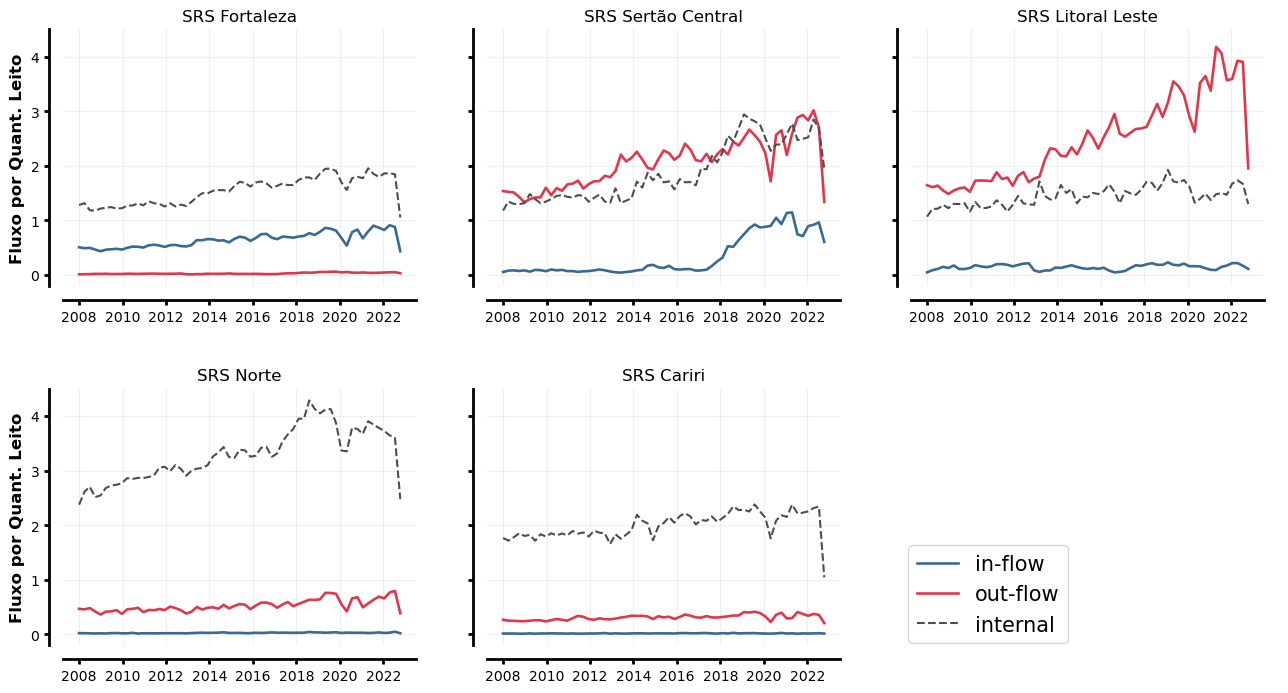

In [25]:
fig, AX = plt.subplots(2,3, figsize=(15.5,8), sharey=True)

AX[1,2].axis('off')

AX[0,0].set_title(macro_dict[1].replace("Superintendência Regional de Saúde", "SRS"))
linein, = AX[0,0].plot(timelst[:-1], macro_flows1["1"]["INCOMING"], color="#396a93", lw=1.9)
lineout, = AX[0,0].plot(timelst[:-1], macro_flows1["1"]["OUTGOING"], color="#e1374b", lw=1.9)
lineins, = AX[0,0].plot(timelst[:-1], macro_flows1["1"]["INTERNAL"], color='#4d4d4d', ls="--")

AX[0,1].set_title(macro_dict[2].replace("Superintendência Regional de Saúde", "SRS"))
AX[0,1].plot(timelst[:-1], macro_flows1["2"]["INCOMING"], color="#396a93", lw=1.9)
AX[0,1].plot(timelst[:-1], macro_flows1["2"]["OUTGOING"], color="#e1374b", lw=1.9)
AX[0,1].plot(timelst[:-1], macro_flows1["2"]["INTERNAL"], color='#4d4d4d', ls="--")

AX[0,2].set_title(macro_dict[3].replace("Superintendência Regional de Saúde", "SRS"))
AX[0,2].plot(timelst[:-1], macro_flows1["3"]["INCOMING"], color="#396a93", lw=1.9)
AX[0,2].plot(timelst[:-1], macro_flows1["3"]["OUTGOING"], color="#e1374b", lw=1.9)
AX[0,2].plot(timelst[:-1], macro_flows1["3"]["INTERNAL"], color='#4d4d4d', ls="--")

AX[1,0].set_title(macro_dict[4].replace("Superintendência Regional de Saúde", "SRS"))
AX[1,0].plot(timelst[:-1], macro_flows1["4"]["INCOMING"], color="#396a93", lw=1.9)
AX[1,0].plot(timelst[:-1], macro_flows1["4"]["OUTGOING"], color="#e1374b", lw=1.9)
AX[1,0].plot(timelst[:-1], macro_flows1["4"]["INTERNAL"], color='#4d4d4d', ls="--")

AX[1,1].set_title(macro_dict[5].replace("Superintendência Regional de Saúde", "SRS"))
AX[1,1].plot(timelst[:-1], macro_flows1["5"]["INCOMING"], color="#396a93", lw=1.9)
AX[1,1].plot(timelst[:-1], macro_flows1["5"]["OUTGOING"], color="#e1374b", lw=1.9)
AX[1,1].plot(timelst[:-1], macro_flows1["5"]["INTERNAL"], color='#4d4d4d', ls="--")

#AX[0,1].plot(timelst[:-1], time_series_macro["2"]["INCOMING"], color='tab:blue')
#AX[0,1].plot(timelst[:-1], time_series_macro["2"]["OUTGOING"], color='tab:red')
#AX[0,1].plot(timelst[:-1], time_series_macro["2"]["INTERNAL"], color='tab:green')
#
#AX[0,2].plot(timelst[:-1], time_series_macro["3"]["INCOMING"], color='tab:blue')
#AX[0,2].plot(timelst[:-1], time_series_macro["3"]["OUTGOING"], color='tab:red')
#AX[0,2].plot(timelst[:-1], time_series_macro["3"]["INTERNAL"], color='tab:green')
#
#AX[1,0].plot(timelst[:-1], time_series_macro["4"]["INCOMING"], color='tab:blue')
#AX[1,0].plot(timelst[:-1], time_series_macro["4"]["OUTGOING"], color='tab:red')
#AX[1,0].plot(timelst[:-1], time_series_macro["4"]["INTERNAL"], color='tab:green')
#
#AX[1,1].plot(timelst[:-1], time_series_macro["5"]["INCOMING"], color='tab:blue')
#AX[1,1].plot(timelst[:-1], time_series_macro["5"]["OUTGOING"], color='tab:red')
#AX[1,1].plot(timelst[:-1], time_series_macro["5"]["INTERNAL"], color='tab:green')

fig.legend([linein, lineout, lineins], ['in-flow', 'out-flow', 'internal'], loc=4, bbox_to_anchor=((0.78,0.1)), prop={'size':15})


for i in range(2):
    for j in range(3):
        AX[i,j].grid(alpha=0.2, zorder=0)
        for sp in ['left', 'right', 'bottom', 'top']:
            AX[i,j].spines[sp].set_linewidth(2)
            AX[i,j].spines[sp].set_position(('outward', 10))
        AX[i,j].spines['right'].set_linewidth(0)
        AX[i,j].spines['top'].set_linewidth(0)
        AX[i,j].yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        AX[i,j].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
        AX[i,j].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        AX[i,j].tick_params(width=2)

AX[0,0].set_ylabel("Fluxo por Quant. Leito", fontsize=12, weight='bold')
AX[1,0].set_ylabel("Fluxo por Quant. Leito", fontsize=12, weight='bold')

fig.subplots_adjust(hspace=0.4)

### **Hospitals**

In [26]:
from networkx.algorithms import bipartite

In [27]:
fname = "CITYHOSPITALFLUX_2019_ALL.gml"
graph = nx.read_gml(os.path.join(basepath, "redes_aih", "novo", fname))
print(graph.number_of_nodes())
nx.is_bipartite(graph)

16714


True

In [28]:
graph.remove_nodes_from(list(nx.isolates(graph)))

In [29]:
bottom_nodes, top_nodes = bipartite.sets(graph)

In [30]:
hospital_net = bipartite.projected_graph(graph, top_nodes)

In [31]:
hospital_net.number_of_edges()

12154

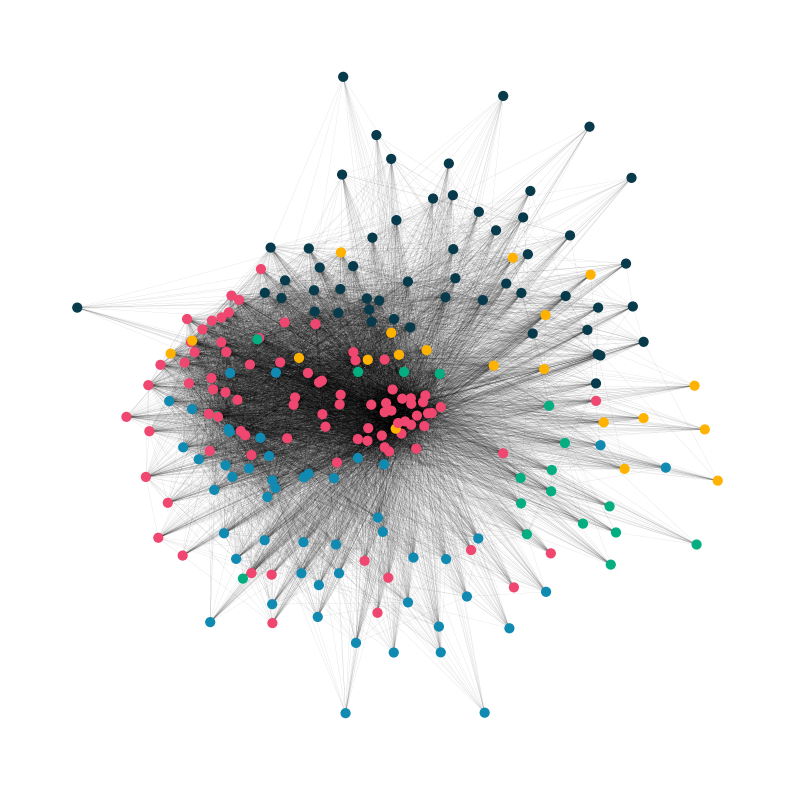

In [32]:
cmap_macro_original = {1: "#ef476f", 2: "#ffb300", 3: "#04ae81", 4: "#118ab2", 5: "#073b4c"}

fig, ax = plt.subplots(1, figsize=(10,10))

macro_color = [ cmap_macro_original[hospital_net.nodes[u]['macro_id']] for u in hospital_net.nodes() ]

nx.draw(hospital_net, pos=nx.spring_layout(hospital_net), node_size=40, width=0.03, node_color=macro_color)

In [33]:
degree_lst = [ deg[1] for deg in hospital_net.degree()]

c:\Users\higor.monteiro\AppData\Local\anaconda3\envs\sevig310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\higor.monteiro\AppData\Local\anaconda3\envs\sevig310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

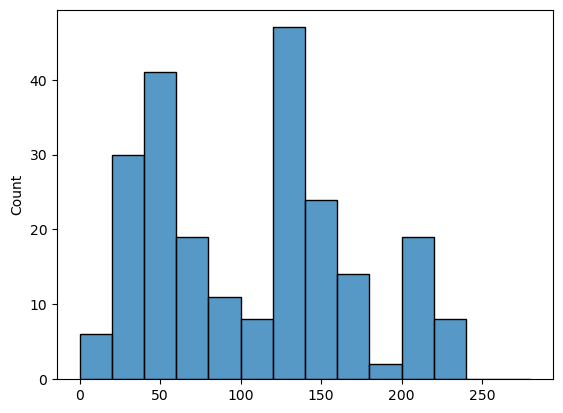

In [34]:
import seaborn as sns
sns.histplot(degree_lst, bins=np.arange(0, 300, 20))

In [35]:
hospital_net.nodes['8937']

{'type': 'hospital',
 'code': '5121957',
 'name': '',
 'municip_code': '230440',
 'macro_id': 1,
 'macro_name': 'Superintendência Regional de Saúde Fortaleza',
 'cres_id': 1,
 'lat': -3.795382,
 'lon': -38.491186}

In [36]:
degree_lst_tup = [ deg for deg in hospital_net.degree()]

In [37]:
degree_lst_tup.sort(key=lambda x: x[1], reverse=True)

In [38]:
input_folder = os.path.join(basepath, "opendatasus", "cnes", "DBF")

In [42]:
def agg_cnes(init_period : str, final_period : str, input_folder : str):
    '''
        Create an aggregated CNES table for a given period containing information
        of all CNES units that existed during this period.

        Args:
        -----
            init_period:
                String. Format "XXUFYYMM", where 'XX' stands for the preffix of the
                CNES file (as described by DATASUS), 'UF' stands for state code to
                consider, and "YYMM" stands for the year and month of the beginning
                of the period.
            final_period:
                String. Format "XXUFYYMM", where 'XX' stands for the preffix of the
                CNES file (as described by DATASUS), 'UF' stands for state code to
                consider, and "YYMM" stands for the year and month of the ending of
                the period.
            input folder:
                String. Path to the folder containing the DBF files.

        Return:
        -------
            cnes_df:
                pandas.DataFrame. Final dataframe containing one single and most 
                recent record for each CNES unit.
    '''
    preffix = init_period[:4]
    list_of_files = glob.glob(os.path.join(input_folder, f'{preffix}*'))

    init_index = [idx for idx, s in enumerate(list_of_files) if init_period in s][0]
    final_index = [idx for idx, s in enumerate(list_of_files) if final_period in s][0]
    if final_index is None:
        raise Exception(f"no file {final_period} was found.")
    list_of_files = list_of_files[init_index:final_index+1]

    cnes_compt_hash = {}
    
    cnes_df = []
    for fname in tqdm(list_of_files):
        cur_df = DBFIX(fname, codec='latin').to_dataframe()
        cnes_df.append( cur_df )
    cnes_df = pd.concat(cnes_df, axis=0)

    # -- keep the most recent record for each CNES
    min_comp = cnes_df.groupby("CNES")["COMPETEN"].min().reset_index()
    max_comp = cnes_df.groupby("CNES")["COMPETEN"].max().reset_index()
    cnes_min = dict(zip(min_comp["CNES"], min_comp["COMPETEN"]))
    cnes_max = dict(zip(max_comp["CNES"], max_comp["COMPETEN"]))
    cnes_df = cnes_df.sort_values(by=["CNES", "COMPETEN"], ascending=False).drop_duplicates(subset=["CNES"], keep='first')
    cnes_df["COMPETEN_MIN"] = cnes_df["CNES"].apply(lambda x: cnes_min[x])
    cnes_df["COMPETEN_MAX"] = cnes_df["CNES"].apply(lambda x: cnes_max[x])
    return cnes_df

In [45]:
ex = agg_cnes("STCE2001", "STCE2112", input_folder)

100%|██████████| 24/24 [01:07<00:00,  2.81s/it]


In [41]:
from tqdm import tqdm

In [48]:
ex#.groupby("CNES")

,CNES,CODUFMUN,COD_CEP,CPF_CNPJ,PF_PJ,NIV_DEP,CNPJ_MAN,COD_IR,REGSAUDE,MICR_REG,...,DT_ATUAL,COMPETEN,NAT_JUR,AP01CV07,AP02CV07,AP03CV07,AP04CV07,AP05CV07,AP06CV07,AP07CV07
0,2497662,230010,63240000,00000000000000,3,3,07411531000116,NaN,0019,0019,...,201912,202001,1244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2497670,230010,63240000,00000000000000,3,3,07411531000116,NaN,0019,0019,...,201912,202001,1244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2497689,230010,63240000,00000000000000,3,3,07411531000116,NaN,0019,0019,...,201912,202001,1244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2726319,230010,63240000,00000000000000,3,3,07411531000116,NaN,0019,0019,...,201910,202001,1244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6431208,230010,63240000,00000000000000,3,3,07411531000116,NaN,NaN,19,...,201912,202001,1244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13417,7585675,231410,62300000,00000000000000,3,3,10462497000113,NaN,NaN,NaN,...,202101,202112,1244,0,0,0,0,0,0,0
13418,7946376,231410,62300000,00000000000000,3,3,10462497000113,NaN,13,13,...,202012,202112,1244,0,0,0,0,0,0,0
13419,9403426,231410,62300000,00000000000000,3,3,10462497000113,NaN,NaN,NaN,...,201911,202112,1244,0,0,0,0,0,0,0
13420,9430970,231410,62300000,00000000000000,3,3,10462497000113,NaN,NaN,NaN,...,202111,202112,1244,0,0,0,0,0,0,0


In [68]:
ex.set_index(keys=["CNES", "COMPETEN"]).sort_index()

CODUFMUN   COD_CEP        CPF_CNPJ PF_PJ NIV_DEP  \
CNES    COMPETEN                                                    
0029793 202001     231290  62010820  33993930000142     3       1   
        202002     231290  62010820  33993930000142     3       1   
        202003     231290  62010820  33993930000142     3       1   
        202004     231290  62010820  33993930000142     3       1   
        202005     231290  62010820  33993930000142     3       1   
...                   ...       ...             ...   ...     ...   
9999310 202108     231130  63900085  00064176983353     1       1   
        202109     231130  63900085  00064176983353     1       1   
        202110     231130  63900085  00064176983353     1       1   
        202111     231130  63900085  00064176983353     1       1   
        202112     231130  63900085  00064176983353     1       1   

                        CNPJ_MAN  COD_IR REGSAUDE MICR_REG DISTRSAN  ...  \
CNES    COMPETEN                                                     ...   
0029793 202001    00000000000000     NaN      NaN      NaN      NaN  ...   
        202002    00000000000000     NaN      NaN      NaN      NaN  ...   
        202003    00000000000000     NaN      NaN      NaN      NaN  ...   
        202004    00000000000000     NaN      NaN      NaN      NaN  ...   
        202005    00000000000000     NaN      NaN      NaN      NaN  ...   
...                          ...     ...      ...      ...      ...  ...   
9999310 202108    00000000000000     NaN      NaN   8ªCRES      NaN  ...   
        202109    00000000000000     NaN      NaN   8ªCRES      NaN  ...   
        202110    00000000000000     NaN      NaN   8ªCRES      NaN  ...   
        202111    00000000000000     NaN      NaN   8ªCRES      NaN  ...   
        202112    00000000000000     NaN      NaN   8ªCRES      NaN  ...   

                 ATEND_PR DT_ATUAL NAT_JUR  AP01CV07  AP02CV07 AP03CV07  \
CNES    COMPETEN                                                          
0029793 202001          1   202001    2135       NaN       NaN      NaN   
        202002          1   202001    2135       NaN       NaN      NaN   
        202003          1   202001    2135       NaN       NaN      NaN   
        202004          1   202001    2135       NaN       NaN      NaN   
        202005          1   202001    2135       NaN       NaN      NaN   
...                   ...      ...     ...       ...       ...      ...   
9999310 202108          1   202001    4000         0         0        0   
        202109          1   202001    4000         0         0        0   
        202110          1   202001    4000         0         0        0   
        202111          1   202001    4000         0         0        0   
        202112          1   202001    4000         0         0        0   

                  AP04CV07 AP05CV07 AP06CV07 AP07CV07  
CNES    COMPETEN                                       
0029793 202001         NaN      NaN      NaN      NaN  
        202002         NaN      NaN      NaN      NaN  
        202003         NaN      NaN      NaN      NaN  
        202004         NaN      NaN      NaN      NaN  
        202005         NaN      NaN      NaN      NaN  
...                    ...      ...      ...      ...  
9999310 202108           0        0        0        0  
        202109           0        0        0        0  
        202110           0        0        0        0  
        202111           0        0        0        0  
        202112           0        0        0        0  

[305604 rows x 206 columns]

In [70]:
ex.groupby("CNES")["COMPETEN"].min()

CNES
0029793    202001
0029807    202001
0032913    202001
0037761    202001
0038997    202001
            ...  
9997709    202001
9998268    202001
9998462    202001
9999183    202001
9999310    202001
Name: COMPETEN, Length: 13739, dtype: object

,CNES,COMPETEN
0,0029793,202112
1,0029807,202112
2,0032913,202112
3,0037761,202112
4,0038997,202112
...,...,...
13734,9997709,202112
13735,9998268,202112
13736,9998462,202112
13737,9999183,202112


In [54]:
import pandas as pd